# Python Code for Project 2 -- Analysis of Avocado Sales in the United States
by Radhika Satapathy, Timothy Quek and Marcial Nava 

Below is the code used to analyze the data and answer the different research questions stated in our original proposal and our final project. 

### <font color=blue>LOADING DATA:</font>
In this section we load the data to be analyzed into pandas data frames.

#### <font color=black>Step 1: Import Required Modules</font>

In [24]:
#CODE

# Import required modules
import datetime
from datetime import datetime as dt
import copy
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)
import copy


#### <font color=black>Step 2: Load Avocado Sales Data</font>

In [41]:
#CODE

# Load the avocado data file
avo_df = pd.read_csv('avocado-rad.csv', parse_dates = ['Date'])

# Display sample data
avo_df.head(5)


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany


In [42]:
# Display data types of columns
avo_df.dtypes


Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
dtype: object

In [43]:
# Replace white spaces in column names
print(avo_df.columns)
avo_df.columns = avo_df.columns.str.replace('\s+', '')
print(avo_df.columns)

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region'],
      dtype='object')
Index(['Unnamed:0', 'Date', 'AveragePrice', 'TotalVolume', '4046', '4225',
       '4770', 'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'type',
       'year', 'region'],
      dtype='object')


#### <font color=black>Step 3: Load Population Data</font>

In [44]:
#CODE

# Load Population Data
pop_df = pd.read_csv("population-rad.csv", index_col='region')
pop_df.head(5)


,2015,2016,2017,2018
region,,,,
California,23498.75,23639.77,23743.83,23917.16
LosAngeles,13283.82,13328.26,13353.91,13451.39
Sacramento,2266.89,2295.23,2324.88,2341.86
SanDiego,3290.04,3317.20,3337.69,3362.05
SanFrancisco,4657.99,4699.08,4727.36,4761.87


### <font color=blue>SANITY CHECK, DATA CLEANSING:</font>
In this section we perform a sanity check of the data and clean the data from any abnormal observation or error.

#### 1.0 Check for Missing Values

In [45]:
# Overall check for missing values
avo_df.isnull().sum()

Unnamed:0       0
Date            0
AveragePrice    0
TotalVolume     0
4046            0
4225            0
4770            0
TotalBags       0
SmallBags       0
LargeBags       0
XLargeBags      0
type            0
year            0
region          0
dtype: int64

#### 2.0 Validate Total Volume Values 

In [46]:
# Extract rows where Total Volume figures don't add up to individual columns

def checkTotal(row):
    ans = row['TotalVolume'] - row['4046'] - row['4225']- row['4770']- row['TotalBags']
    return int(ans)

avo_df['check1'] = avo_df.apply(checkTotal, axis=1)
avo_df

# sort values in descending order of difference
check1_sort = avo_df[avo_df['check1'] > 0].sort_values('check1', ascending=False)

# filter just the necessary columns and view
check1_sort_filter = check1_sort.filter(items=['Date', 'region', 'type', 'check1', 'TotalVolume','4046', '4225', '4770', 'TotalBags'])
#check1_sort_filter

# 209 rows where TotalVolume does not add up


#### 3.0 Update Total Volumes of Inconsistent Rows

In [47]:
# update TotalVolumes correctly
def updateTotal(row):
    ans = row['4046'] + row['4225'] + row['4770'] + row['TotalBags']
    return int(ans)

avo_df['TotalVolume'] = avo_df.apply(updateTotal, axis=1)

# visually verify data for a region or city
#avo_df[avo_df.region == 'California']

# once again check to ensure Total Volumes add up correctly
def checkTotal(row):
    ans = row['TotalVolume'] - row['4046'] - row['4225']- row['4770']- row['TotalBags']
    return int(ans)

avo_df['check1'] = avo_df.apply(checkTotal, axis=1)
avo_df[avo_df['check1'] > 0].count()

Unnamed:0       0
Date            0
AveragePrice    0
TotalVolume     0
4046            0
4225            0
4770            0
TotalBags       0
SmallBags       0
LargeBags       0
XLargeBags      0
type            0
year            0
region          0
check1          0
dtype: int64

### <font color=blue>AGGREGATING AT REGIONAL LEVEL AND MERGING WITH POPULATION DATA:</font>
 We merge two data sets avocado.csv and population.csv, in preparation for subsequent data analysis.

#### 1.0 Compute TotalSales with corrected TotalVolumes

In [48]:
# add column TotalSales and set it to the product of TotalVolume and Average Price
avo_df['TotalSales'] = avo_df['TotalVolume']*avo_df['AveragePrice']
avo_df.filter(items = ['region', 'Date', 'AveragePrice', 'TotalVolume', 'TotalSales'])
avo_df.head(2)

,Unnamed:0,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,check1,TotalSales
0,0,2015-12-27,1.33,64236,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany,0,85433.88
1,1,2015-12-20,1.35,54876,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany,0,74082.60


#### 2.0 Obtain Total Volume and TotalSales by Region &Year

In [49]:

# subset avocado data based on regions we want to look at (update the region list below accordingly)
region_list = ['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'West', 'WestTexNewMexico', 'TotalUS']

# region_list = ['California', 'GreatLakes', 'Midsouth', 'Northeast', 'Plains', 
#                'SouthCentral', 'Southeast', 'West']

avo_regions = avo_df.loc[avo_df['region'].isin(region_list)]
avo_regions['region'].unique()

# SPLIT avocado data based on region and year
avo_by_region_year = avo_regions.groupby([avo_regions.region, avo_regions.year])
avo_by_region_year

# # APPLY sum() and COMBINE to obtain Total Volume by region & year
# avo_TotalVolume_by_region_year = avo_by_region_year.sum().filter(items =['region', 'TotalVolume'])
# print(avo_TotalVolume_by_region_year)

# unstack index to create TotalVolume_by_region_year pivot table
avo_TotalVolume_by_region_year = avo_by_region_year.sum().filter(items =['region', 'TotalVolume']).unstack()
# print(avo_TotalVolume_by_region_year)

# APPLY sum() and COMBINE to obtain Total Sales by region & year
# avo_TotalSales_by_region_year = avo_by_region_year.sum().filter(items =['region', 'TotalSales'])
# print(avo_TotalSales_by_region_year)

# unstack index to create TotalSales_by_region_year pivot table
avo_TotalSales_by_region_year = avo_by_region_year.sum().filter(items =['region', 'TotalSales']).unstack()
# print(avo_TotalSales_by_region_year)


# # Plot Volume & Sales by Region & Year
#avo_TotalVolume_by_region_year.plot(kind='bar', figsize=(20,10), linewidth=20)
#avo_TotalSales_by_region_year.plot(kind='bar', figsize=(20,10), linewidth=20)



# # Save results to csv
avo_TotalVolume_by_region_year.to_csv('VolumeRegionYear.csv')
avo_TotalSales_by_region_year.to_csv('SalesRegionYear.csv')


#### 3.0 Merge 'Total Sales by Region and Year' (generated in previous code cell) with 'Population' data

In [50]:
# Load Population Data
pop_df = pd.read_csv("population-rad.csv", index_col='region').sort_index()

# rename columns
pop_df.columns = ['2015_Pop','2016_Pop','2017_Pop','2018_Pop']

# Load Sales by Region and Year Data
sales_df = pd.read_csv('SalesRegionYear.csv', index_col='region', header=2).sort_index()

# rename columns
sales_df.columns = ['2015_Sales','2016_Sales','2017_Sales','2018_Sales']

# check number of rows
# print(pop_df.count())
# print(sales_df.count())

# merge both data frames
combined_df_sales = sales_df.merge(pop_df, left_index=True, right_index=True)

#print(combined_df_sales.count())
### 2 rows inconsistent###

#define perCapita Sales functions
def calcPerCapitaSales2015(row):
    ans = row['2015_Sales'].astype('float') / (row['2015_Pop'] * 1000)
    return ans

combined_df_sales['Sales_Per_Capita_2015'] = combined_df_sales.apply(calcPerCapitaSales2015, axis=1)


def calcPerCapitaSales2016(row):
    ans = row['2016_Sales'].astype('float') / (row['2016_Pop'] * 1000)
    return ans

combined_df_sales['Sales_Per_Capita_2016'] = combined_df_sales.apply(calcPerCapitaSales2016, axis=1)

def calcPerCapitaSales2017(row):
    ans = row['2017_Sales'].astype('float') / (row['2017_Pop'] * 1000)
    return ans

combined_df_sales['Sales_Per_Capita_2017'] = combined_df_sales.apply(calcPerCapitaSales2017, axis=1)

def calcPerCapitaSales2018(row):
    ans = row['2018_Sales'].astype('float') / (row['2018_Pop'] * 1000)
    return ans

combined_df_sales['Sales_Per_Capita_2018'] = combined_df_sales.apply(calcPerCapitaSales2018, axis=1)

# save combined file
combined_df_sales.to_csv('PerCapitaSalesByRegionYear.csv')

#visually inspect combined file
#combined_df_sales

#### 4.0 Merge 'Total Volume by Region and Year' (generated in previous code cell) with 'Population' data

In [51]:
# Load Population Data
pop_df = pd.read_csv("population-rad.csv", index_col='region').sort_index()

# rename columns
pop_df.columns = ['2015_Pop','2016_Pop','2017_Pop','2018_Pop']

# Load Volume by Region and Year Data
volume_df = pd.read_csv('VolumeRegionYear.csv', index_col='region', header=2).sort_index()

# rename columns
volume_df.columns = ['2015_Volume','2016_Volume','2017_Volume','2018_Volume']

# check number of rows
# print(pop_df.count())
# print(volume_df.count())

# merge both data frames
combined_df_volume = volume_df.merge(pop_df, left_index=True, right_index=True)

# print(combined_df_volume.count())
### 2 rows inconsistent###

# define perCapita Volume functions
def calcPerCapitaVol2015(row):
    ans = row['2015_Volume'].astype('float') / (row['2015_Pop'] * 1000)
    return ans

combined_df_volume['Vol_Per_Capita_2015'] = combined_df_volume.apply(calcPerCapitaVol2015, axis=1)


def calcPerCapitaVol2016(row):
    ans = row['2016_Volume'].astype('float') / (row['2016_Pop'] * 1000)
    return ans

combined_df_volume['Vol_Per_Capita_2016'] = combined_df_volume.apply(calcPerCapitaVol2016, axis=1)

def calcPerCapitaVol2017(row):
    ans = row['2017_Volume'].astype('float') / (row['2017_Pop'] * 1000)
    return ans

combined_df_volume['Vol_Per_Capita_2017'] = combined_df_volume.apply(calcPerCapitaVol2017, axis=1)

def calcPerCapitaVol2018(row):
    ans = row['2018_Volume'].astype('float') / (row['2018_Pop'] * 1000)
    return ans

combined_df_volume['Vol_Per_Capita_2018'] = combined_df_volume.apply(calcPerCapitaVol2018, axis=1)

# save combined file
combined_df_volume.to_csv('PerCapitaVolumeByRegionYear.csv')

# visually inspect combined file
# combined_df_volume



### <font color=blue>Research Question: Which of the regional markets are best for market entry?</font>

#### <font color=green>1.0 Look at Total Volume by Region</font>

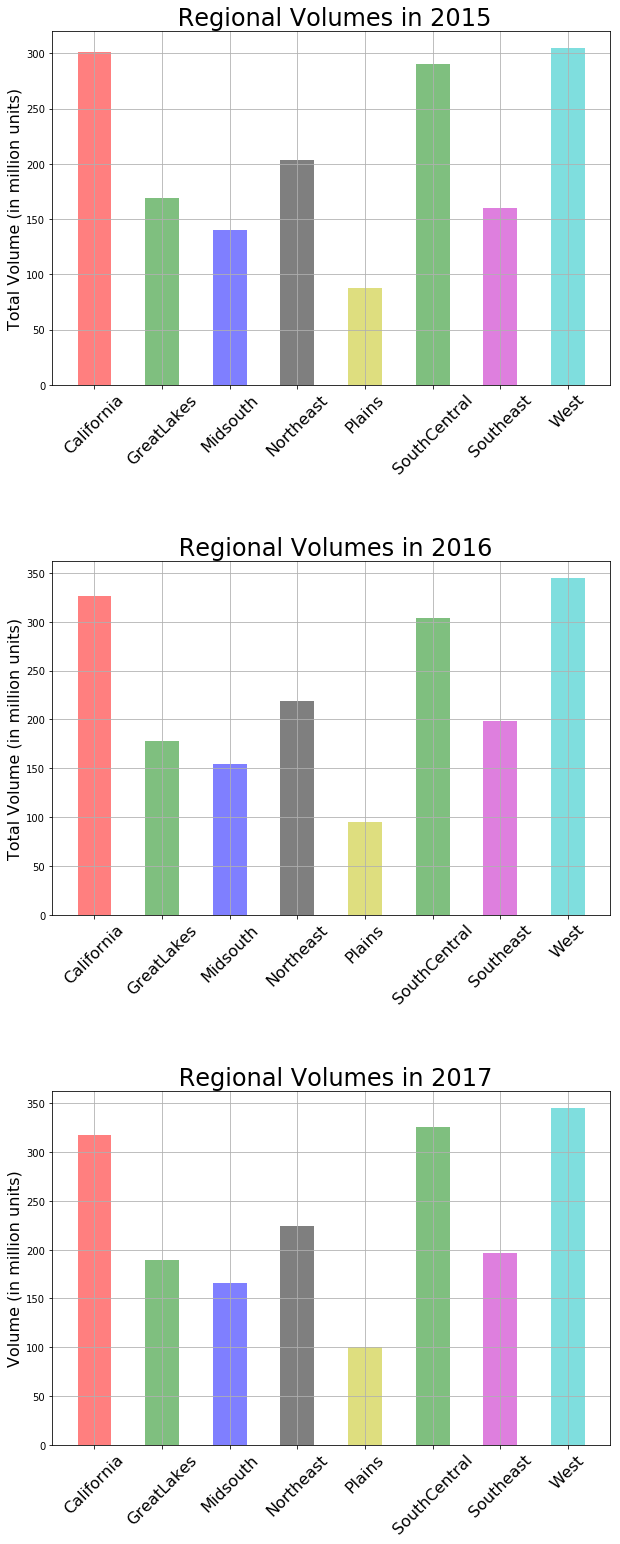

In [52]:
# Total Volume by Region

regions = ['California','West','Plains','SouthCentral','GreatLakes','Midsouth','Southeast','Northeast']

df = combined_df_volume.loc[combined_df_volume.index.isin(regions)]
df.sort_values(by='2017_Volume')

# Plot PerCapita Volume by region for each year
x = df.index
y1 = df['2015_Volume']
y2 = df['2016_Volume']
y3 = df['2017_Volume']
y4 = df['2018_Volume']

fig, axes = plt.subplots(3, 1, figsize=(10,26))

# line plot
# axes[0].plot(x, y1, color="purple", lw=1, ls='-', marker='s', markersize=8, 
#        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue")

my_colors = 'rgbkygmc'  #red, green, blue, black, etc.
    
axes[0].bar(x, y1/1000000, align="center", width=0.5, alpha=0.5, color=my_colors)

axes[1].bar(x, y2/1000000, align="center", width=0.5, alpha=0.5, color=my_colors)

axes[2].bar(x, y3/1000000, align="center", width=0.5, alpha=0.5, color=my_colors)

# rotate labels for all subplots
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(fontsize=16,rotation=45)

# increase space between subplots (wspace->side by side plots, hspace->top-bottom plots )
fig.subplots_adjust(hspace=.5)

axes[0].set_ylabel("Total Volume (in million units)", fontsize=16)
axes[0].set_title(" Regional Volumes in 2015", fontsize=24)

axes[1].set_ylabel("Total Volume (in million units)", fontsize=16)
axes[1].set_title(" Regional Volumes in 2016", fontsize=24)

axes[2].set_ylabel("Volume (in million units)", fontsize=16)
axes[2].set_title(" Regional Volumes in 2017", fontsize=24)

axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)

#### <font color=red>Insight 1:</font>
<font color=blue>We first looked at total sales of avocado and found that California, South Central and West were the biggest markets in terms of volume, in excess of 300 million avocados sold per year. So we chose to take a closer look at these regions.</font>


#### <font color=green>2.0 Look at Total Volumes in the top 3 biggest markets</font>

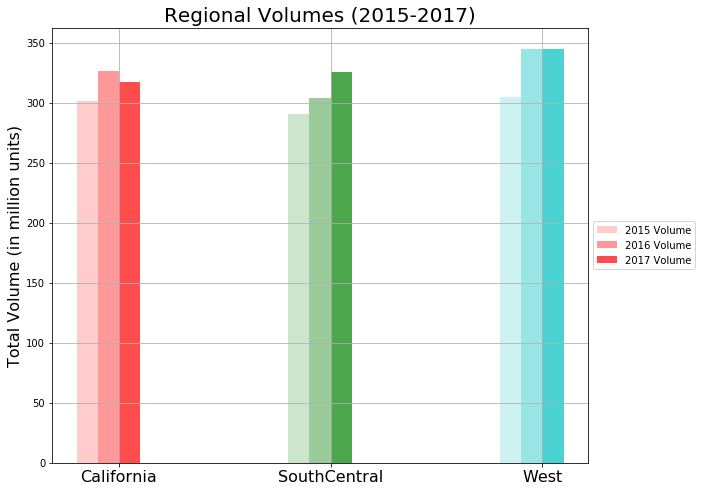

In [53]:
# Volumes in top 3 regions

regions = ['California','West','SouthCentral']
df = combined_df_volume.loc[combined_df_volume.index.isin(regions)]
df

x = df.index
y1 = df['2015_Volume']
y2 = df['2016_Volume']
y3 = df['2017_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

# create an empty plot
fig, ax = plt.subplots(figsize=(12, 8))

my_colors = 'rgc'

ax.grid(True)
# plot the 3 bars
bar1 = plt.bar(index - bar_width, y1*1/1000000, bar_width, color=my_colors, alpha=0.2, label='2015 Volume')
bar2 = plt.bar(index, y2*1/1000000, bar_width, color=my_colors, alpha=0.4, label='2016 Volume')
bar2 = plt.bar(index + bar_width, y3*1/1000000, bar_width, color=my_colors, alpha=0.7, label='2017 Volume')

# labeling
plt.ylabel('Total Volume (in million units)', fontsize = 16)
plt.title('Regional Volumes (2015-2017)', fontsize = 20)
plt.xticks(index + bar_width / 2, x,fontsize = 16 )

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()



#### <font color=red>Insight 2:</font>
<font color=blue>When we looked at the volumes of these three top markets for the time period, we found that although there was a noticeable increase in sales from 2015 to 2016, the following year, of the three, only the South Central region seemed to continue to display steady growth.<br>
Furthermore, the percentage changes were significant for a deeper dive analysis. See below</font>


#### <font color=green>3.0 Look at % changes in Total Volumes in the top 3 biggest markets</font>

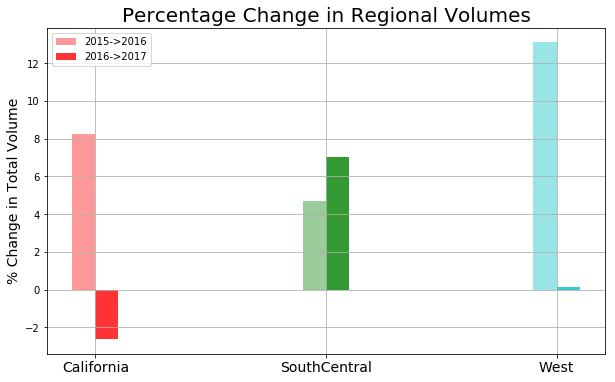

In [54]:
# Percentage change in Volume by region

regions = ['California','West','SouthCentral']

df = combined_df_volume.loc[combined_df_volume.index.isin(regions)]
df.sort_values(by='2017_Volume')

x = df.index
y1 = (df['2016_Volume']-df['2015_Volume']) * 100 / df['2015_Volume']
y2 = (df['2017_Volume']-df['2016_Volume']) * 100 / df['2016_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

my_colors = 'rgc'

# create an empty plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(True)
# plot the two bars
bar1 = plt.bar(index, y1, bar_width, color=my_colors, alpha=0.4, label='2015->2016')
bar2 = plt.bar(index + bar_width, y2, bar_width, color=my_colors, alpha=0.8, label='2016->2017')


# labeling
plt.ylabel('% Change in Total Volume', fontsize = 14)
plt.title('Percentage Change in Regional Volumes', fontsize = 20)
plt.xticks(index + bar_width / 2, x,  fontsize = 14 )


plt.legend()

plt.show()






#### <font color=red>Insight 3:</font>
<font color=blue> Although there was significant increase between 2015 and 2016 in terms of total volume, two out of the three markets suffered over a 10% slump in the market the following year while South Central continued to display a steady growth. So we took a deeper dive to examine the sales volumes of the constituent cities of each of these regions to see of we could find out any interesting patterns that might tell us why this may be the case. </font>


####  <font color=green>4.0 Look at Total Volumes in Cities in the top 3 regional markets and % changes in Total Volume</font>

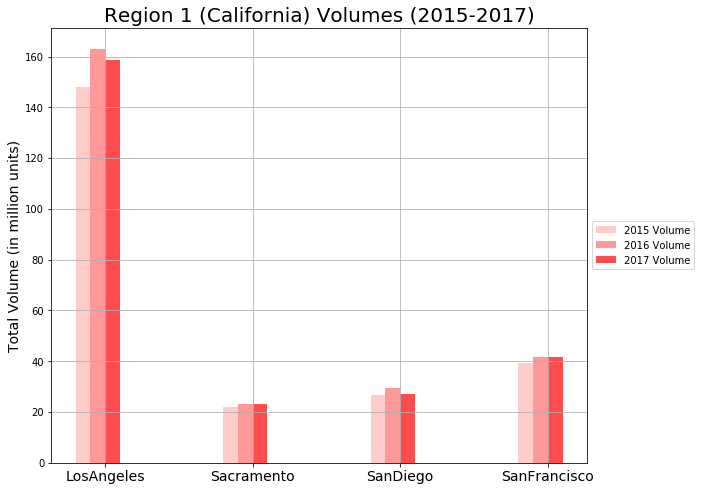

In [55]:
cities1 = ['LosAngeles', 'Sacramento', 'SanDiego', 'SanFrancisco']

df = combined_df_volume.loc[combined_df_volume.index.isin(cities1)]
df

x = df.index
y1 = df['2015_Volume']
y2 = df['2016_Volume']
y3 = df['2017_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

# create an empty plot
fig, ax = plt.subplots(figsize=(12, 8))


# plot the 3 bars
plt.grid(True)
bar1 = plt.bar(index - bar_width, y1*1/1000000, bar_width, color='r', alpha=0.2, label='2015 Volume')
bar2 = plt.bar(index, y2*1/1000000, bar_width, color='r', alpha=0.4, label='2016 Volume')
bar3 = plt.bar(index + bar_width, y3*1/1000000, bar_width, color='r', alpha=0.7, label='2017 Volume')

# labeling
plt.ylabel('Total Volume (in million units)', fontsize = 14)
plt.title('Region 1 (California) Volumes (2015-2017)', fontsize = 20)
plt.xticks(index + bar_width / 2, x,  fontsize = 14 )

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




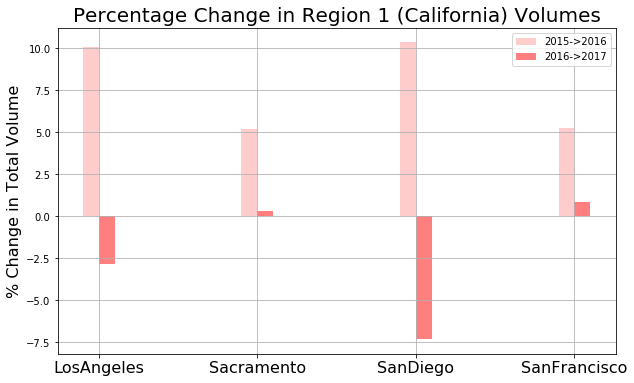

In [56]:
# Percentage change in Volume by city

cities1 = ['LosAngeles', 'Sacramento', 'SanDiego', 'SanFrancisco']

df = combined_df_volume.loc[combined_df_volume.index.isin(cities1)]
df

x = df.index
y1 = (df['2016_Volume']-df['2015_Volume']) * 100 / df['2015_Volume']
y2 = (df['2017_Volume']-df['2016_Volume']) * 100 / df['2016_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

my_colors = 'r'

# create an empty plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(True)
# plot the two bars
bar1 = plt.bar(index, y1, bar_width, color=my_colors, alpha=0.2, label='2015->2016')
bar2 = plt.bar(index + bar_width, y2, bar_width, color=my_colors, alpha=0.5, label='2016->2017')


# labeling
plt.ylabel('% Change in Total Volume', fontsize = 16)
plt.title('Percentage Change in Region 1 (California) Volumes', fontsize = 20)
plt.xticks(index + bar_width / 2, x, fontsize = 16 )


plt.legend()

plt.show()


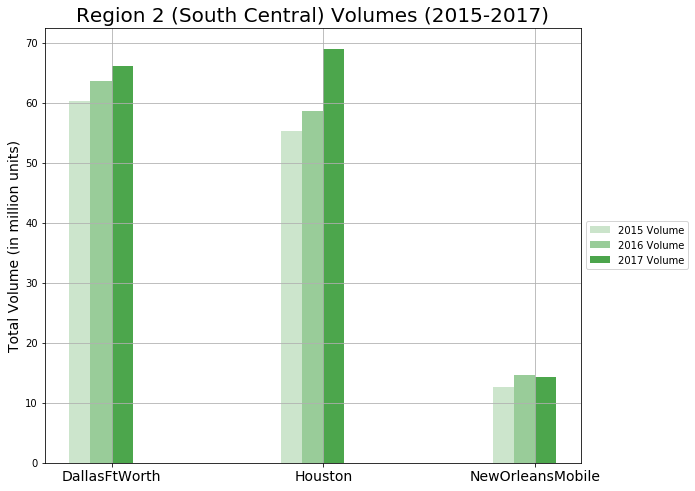

In [57]:
cities2 = ['DallasFtWorth', 'Houston', 'NewOrleansMobile',]

df = combined_df_volume.loc[combined_df_volume.index.isin(cities2)]
df

x = df.index
y1 = df['2015_Volume']
y2 = df['2016_Volume']
y3 = df['2017_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

# create an empty plot
fig, ax = plt.subplots(figsize=(12, 8))


# plot the 3 bars
plt.grid(True)
bar1 = plt.bar(index - bar_width, y1*1/1000000, bar_width, color='g', alpha=0.2, label='2015 Volume')
bar2 = plt.bar(index, y2*1/1000000, bar_width, color='g', alpha=0.4, label='2016 Volume')
bar3 = plt.bar(index + bar_width, y3*1/1000000, bar_width, color='g', alpha=0.7, label='2017 Volume')

# labeling
plt.ylabel('Total Volume (in million units)', fontsize = 14)
plt.title('Region 2 (South Central) Volumes (2015-2017)', fontsize = 20)
plt.xticks(index + bar_width / 2, x,  fontsize = 14 )

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




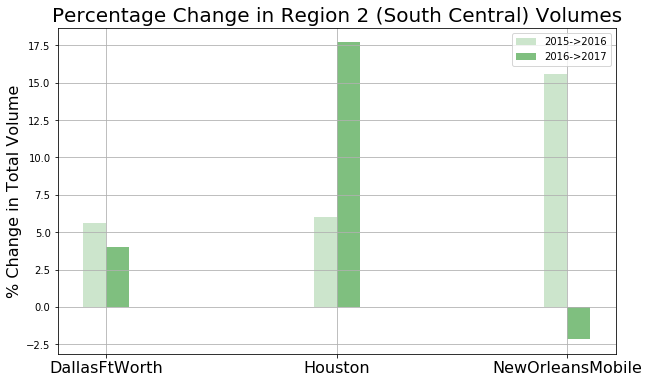

In [58]:
cities2 = ['DallasFtWorth', 'Houston', 'NewOrleansMobile',]

df = combined_df_volume.loc[combined_df_volume.index.isin(cities2)]
df

x = df.index
y1 = (df['2016_Volume']-df['2015_Volume']) * 100 / df['2015_Volume']
y2 = (df['2017_Volume']-df['2016_Volume']) * 100 / df['2016_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

my_colors = 'g'

# create an empty plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(True)
# plot the two bars
bar1 = plt.bar(index, y1, bar_width, color=my_colors, alpha=0.2, label='2015->2016')
bar2 = plt.bar(index + bar_width, y2, bar_width, color=my_colors, alpha=0.5, label='2016->2017')


# labeling
plt.ylabel('% Change in Total Volume', fontsize = 16)
plt.title('Percentage Change in Region 2 (South Central) Volumes', fontsize = 20)
plt.xticks(index + bar_width / 2, x, fontsize = 16 )


plt.legend()

plt.show()

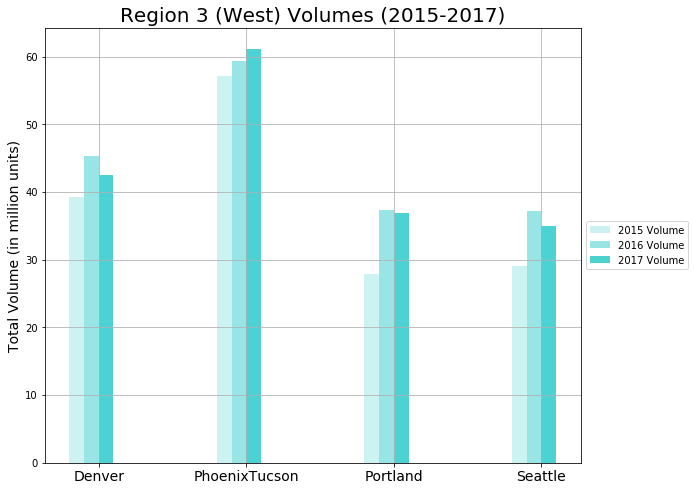

In [59]:
cities3 = ['Denver', 'PhoenixTucson', 'Portland', 'Seattle']

df = combined_df_volume.loc[combined_df_volume.index.isin(cities3)]
df

x = df.index
y1 = df['2015_Volume']
y2 = df['2016_Volume']
y3 = df['2017_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

# create an empty plot
fig, ax = plt.subplots(figsize=(12, 8))

# plot the 3 bars
plt.grid(True)
bar1 = plt.bar(index - bar_width, y1*1/1000000, bar_width, color='c', alpha=0.2, label='2015 Volume')
bar2 = plt.bar(index, y2*1/1000000, bar_width, color='c', alpha=0.4, label='2016 Volume')
bar3 = plt.bar(index + bar_width, y3*1/1000000, bar_width, color='c', alpha=0.7, label='2017 Volume')

# labeling
plt.ylabel('Total Volume (in million units)', fontsize = 14)
plt.title('Region 3 (West) Volumes (2015-2017)', fontsize = 20)
plt.xticks(index + bar_width / 2, x, fontsize = 14 )

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




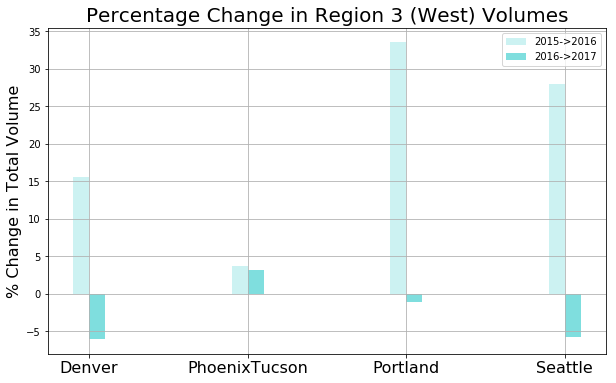

In [60]:
cities3 = ['Denver', 'PhoenixTucson', 'Portland', 'Seattle']

df = combined_df_volume.loc[combined_df_volume.index.isin(cities3)]
df

x = df.index
y1 = (df['2016_Volume']-df['2015_Volume']) * 100 / df['2015_Volume']
y2 = (df['2017_Volume']-df['2016_Volume']) * 100 / df['2016_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.1

my_colors = 'c'

# create an empty plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(True)
# plot the two bars
bar1 = plt.bar(index, y1, bar_width, color=my_colors, alpha=0.2, label='2015->2016')
bar2 = plt.bar(index + bar_width, y2, bar_width, color=my_colors, alpha=0.5, label='2016->2017')


# labeling
plt.ylabel('% Change in Total Volume', fontsize = 16)
plt.title('Percentage Change in Region 3 (West) Volumes', fontsize = 20)
plt.xticks(index + bar_width / 2, x, fontsize = 16 )


plt.legend()

plt.show()


#### <font color=red>Insight 4:</font>
<font color=blue> Looking at city level data, we identified the presence of strong markets in South Central. Houston with a 6% increase over 2015 and almost an 18% increase in 2017 seemed to be the main driver in the region. <br><br> So then we asked ourselves, clearly from 2015 to 2016, all these cities saw an significant increase in avocado sales, so what is it that may be causing some markets to continue to exhibit a strong growth rate and some not. Could there be another factor that is influencing demand? <br><br> This is when we decided to look at average prices of avocados in cities that did well with those that did not do well within the same region.<br><br> So we split the cities up into 2 groups to look at average prices over the time period. <br><br> Growing Markets: Houston, Dallas, PhoenixTucson<br><br> Slumping Markets: Los Angeles, San Diego, Seattle, Denver</font>

#### <font color=green>5.0 Look at % change in Volume across cities</font>

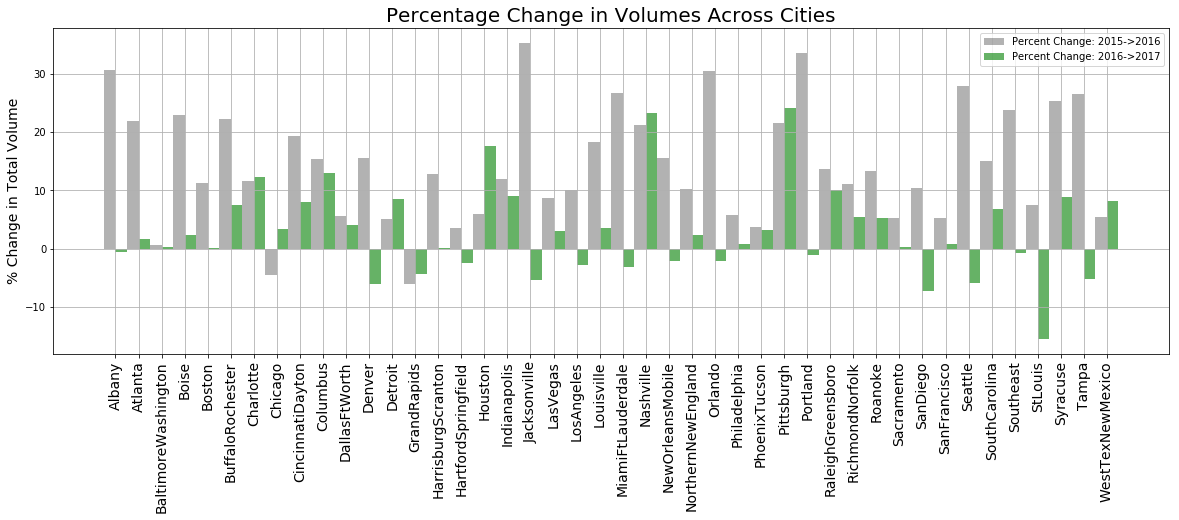

In [61]:
# % change in Volume across cities

cities = ['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Nashville', 'NewOrleansMobile', 'NewYork',
       'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'WestTexNewMexico']

df = combined_df_volume.loc[combined_df_volume.index.isin(cities)]
df

x = df.index
y1 = (df['2016_Volume']-df['2015_Volume']) * 100 / df['2015_Volume']
y2 = (df['2017_Volume']-df['2016_Volume']) * 100 / df['2016_Volume']

# create a numerical index that can be used as the basis for x-axis
index = np.arange(len(x))
bar_width = 0.5

# create an empty plot
fig, ax = plt.subplots(figsize=(20, 6))

ax.grid(True)
# plot the two bars
bar1 = plt.bar(index, y1, bar_width, color='k', alpha=0.3, label='Percent Change: 2015->2016')
bar2 = plt.bar(index + bar_width, y2, bar_width, color='g', alpha=0.6, label='Percent Change: 2016->2017')


# labeling
plt.ylabel('% Change in Total Volume', fontsize = 14)
plt.title('Percentage Change in Volumes Across Cities', fontsize = 20)
plt.xticks(index + bar_width / 2, x, fontsize = 14, rotation=90 )


plt.legend()

plt.show()


#### <font color=green>6.0 Look at prices across 'growing' and 'slumping' markets</font>

In [62]:
# look at average prices by city across years for these subsets

successful_cities = ['Houston', 'DallasFtWorth', 'PhoenixTucson', 'SanFrancisco', 'Sacramento']
unsuccessful_cities = ['LosAngeles', 'SanDiego', 'Seattle', 'Denver', 'NewOrleansMobile', 'TotalUS']

df1 = avo_df.loc[avo_df.region.isin(successful_cities)]
price_df1 = df1.groupby(['year','region']).mean().filter(items=['AveragePrice'])
print("Successful Cities\n", price_df1.unstack().T)

print("\n")

df2 = avo_df.loc[avo_df.region.isin(unsuccessful_cities)]
price_df2 = df2.groupby(['year','region']).mean().filter(items=['AveragePrice'])
print("Unsuccessful Cities\n", price_df2.unstack().T)





Successful Cities
 year                        2015  2016  2017  2018
             region                               
AveragePrice DallasFtWorth  1.08  1.00  1.18  1.10
             Houston        1.05  0.99  1.10  1.04
             PhoenixTucson  1.16  1.26  1.27  1.16
             Sacramento     1.45  1.67  1.77  1.47
             SanFrancisco   1.62  1.88  1.97  1.55


Unsuccessful Cities
 year                           2015  2016  2017  2018
             region                                  
AveragePrice Denver            1.19  1.09  1.36  1.28
             LosAngeles        1.15  1.08  1.38  1.35
             NewOrleansMobile  1.27  1.25  1.42  1.20
             SanDiego          1.27  1.31  1.58  1.48
             Seattle           1.42  1.30  1.60  1.45
             TotalUS           1.26  1.26  1.44  1.31


#### <font color=red>Insight 5:</font>
<font color=blue> While all of the cities displaying positive growth in 2017 managed to keep the price increases to under the national average of 12%, almost all of the slumping markets exhibited almost double that increase in average prices. It’s no wonder that avocadoes did not sell as much in these regions in 2017.
</font>

